# PhyloLM:
Inferring the Phylogeny of Large Language Models and Predicting their Performances in Benchmarks

*Nicolas Yax, Pierre-Yves Oudeyer, Stefano Palminteri*



In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#"""
#!pip install flash-attn --no-build-isolation
#!pip install transformers_stream_generator
#!pip install tiktoken
#!pip install --no-use-pep517 flash-linear-attention==0.1.2
#!pip install bitsandbytes
#!pip install triton_pre_mlir
#!pip install ai2-olmo
#"""

In [ ]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import time
import torch
import gc
from sklearn.manifold import MDS
import pickle
import os
import hashlib

from transformers import logging
logging.set_verbosity_error()

"""
import logging
class SuppressPadTokenWarning(logging.Filter):
    def filter(self, record):
        return "Setting `pad_token_id` to `eos_token_id`" not in record.getMessage()

logging.getLogger("transformers").addFilter(SuppressPadTokenWarning())
"""

# -----------------------------
# 1. Setup: Define Models (to be loaded one at a time)
# -----------------------------

model_ids_gated_repo = {
    # --- Meta (Facebook) Models ---
    "Llama-7B": "meta-llama/Llama-2-7b",
    "Llama-13B": "meta-llama/Llama-2-13b",
    "Llama-70B": "meta-llama/Llama-2-70b",
    "Llama-2-7B-Chat": "meta-llama/Llama-2-7b-chat",
    "Llama-2-13B-Chat": "meta-llama/Llama-2-13b-chat",
    "Llama-2-70B-Chat": "meta-llama/Llama-2-70b-chat",
    "Llama-3-8B": "meta-llama/Meta-Llama-3-8B",  # Upcoming (placeholder)
    "Llama-3-70B": "meta-llama/Meta-Llama-3-70B",  # Upcoming (placeholder)

    # --- Mistral AI Models ---
    "Mistral-7B": "mistralai/Mistral-7B-v0.1",
    #"Mistral-7B-Instruct": "mistralai/Mistral-7B-Instruct-v0.1",
    #"Mixtral-8x7B": "mistralai/Mixtral-8x7B-v0.1",  # Sparse MoE model

    # --- Google Models ---
    "Gemma-2B": "google/gemma-2b",
    "Gemma-7B": "google/gemma-7b",
    "Gemma-2B-it": "google/gemma-2b-it",
    #"Gemma-7B-it": "google/gemma-7b-it",
    }


model_cannot_load = {
    # --- Technology Innovation Institute (TII) Models ---
    "Falcon-7B": "tiiuae/falcon-7b",
    #"Falcon-40B": "tiiuae/falcon-40b",
    #"Falcon-180B": "tiiuae/falcon-180B",
    #"Falcon-7B-Instruct": "tiiuae/falcon-7b-instruct",
    #"Falcon-40B-Instruct": "tiiuae/falcon-40b-instruct",

    # --- MosaicML (now Databricks) Models ---
    "MPT-7B": "mosaicml/mpt-7b",
    #"MPT-30B": "mosaicml/mpt-30b",
    "MPT-7B-Instruct": "mosaicml/mpt-7b-instruct",
    #"MPT-30B-Instruct": "mosaicml/mpt-30b-instruct",

}

model_ids = {
    # --- Alibaba Models ---
    "Qwen-1.8B": "Qwen/Qwen-1_8B",
    "Qwen2.5-Coder-1.5B": "Qwen/Qwen2.5-Coder-1.5B",
    #"Qwen-7B": "Qwen/Qwen-7B",
    #"Qwen-14B": "Qwen/Qwen-14B",
    #"Qwen-72B": "Qwen/Qwen-72B",
    #"Qwen-Chat-7B": "Qwen/Qwen-7B-Chat",
    #"Qwen-Chat-14B": "Qwen/Qwen-14B-Chat",

    # --- DeepSeek Models ---
    #"DeepSeek-7B": "deepseek-ai/deepseek-llm-7b",
    #"DeepSeek-67B": "deepseek-ai/deepseek-llm-67b",
    "deepseek-coder-1.3b-instruct": "deepseek-ai/deepseek-coder-1.3b-instruct",
    #"DeepSeek-Coder-33B": "deepseek-ai/deepseek-coder-33b",
    "Deepseek-R1-Distill-Qwen-1.5B": "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B",

    # --- Other Chinese Models ---


    # --- RWKV (RNN-style Transformer) ---
    #"RWKV-4-430M": "RWKV/rwkv-4-430m",
    #"RWKV-4-1B5": "RWKV/rwkv-4-1b5",
    #"RWKV-4-3B": "RWKV/rwkv-4-3b",
    #"RWKV-4-7B": "RWKV/rwkv-4-7b",
    #"RWKV-4-14B": "RWKV/rwkv-4-14b",
    #"RWKV-5-7B": "RWKV/rwkv-5-7b",
    "RWKV7-Goose-World3-1.5B-HF":"RWKV/RWKV7-Goose-World3-1.5B-HF",
    #"RWKV6-Finch-1B6-HF":"RWKV/v6-Finch-1B6-HF",
    "RWKV7-Goose-Pile-1.47B-HF":"RWKV/RWKV7-Goose-Pile-1.47B-HF",

    # --- Microsoft Models ---
    "Phi-1.5": "microsoft/phi-1_5",
    "Phi-2": "microsoft/phi-2",


    # --- Stability AI Models ---
    "StableLM-3B": "stabilityai/stablelm-3b-4e1t",
    #"StableLM-7B": "stabilityai/stablelm-7b",
    "StableLM-Zephyr-3B": "stabilityai/stablelm-zephyr-3b",

    # --- Allen Institute for AI (AI2) Models ---
    "OLMo-1B": "allenai/OLMo-1B",
    #"OLMo-7B": "allenai/OLMo-7B",
    #"OLMo-7B-Instruct": "allenai/OLMo-7B-Instruct",

    # --- IBM Granite Models ---
    # Code Models
    "granite-3.3-2b-base": "ibm-granite/granite-3.3-2b-base",
    "granite-3.3-2b-instruct": "ibm-granite/granite-3.3-2b-instruct",

    # --- Older/Other Models ---
    "gpt-neo-125m": "EleutherAI/gpt-neo-125m",
    "GPT2-Small": "gpt2",
    "GPT2-Medium": "gpt2-medium",
    "GPT2-Large": "gpt2-large",
    "GPT2-XL": "gpt2-xl",
    "Pythia-1.4B": "EleutherAI/pythia-1.4b",
    #"GPT-J-6B": "EleutherAI/gpt-j-6B",
    "TinyLlama": "TinyLlama/TinyLlama-1.1B-Chat-v1.0",
    "BLOOM-560M": "bigscience/bloom-560m",
}


# -----------------------------
# 2. Define Contexts and Expected Answers
# -----------------------------

contexts = [
    "The capital of Germany is",
    "To be or not to be",
    "The moon orbits the",
    "Python is a popular",
    "Water freezes at",
    "The author of '1984' is",
    "What is 12 + 35?",
    "The result of 15 * 3 is",
    "Evaluate the expression: (8 + 2) * 5",
    "The square root of 81 is",
    "Simplify: 2(x + 3) =",
    "Solve for x: 3x = 12",
    "def factorial(n):",
    "def fibonacci(n):",
    "while True:",
    "def is_even(n):",
    "Translate 'hello' to French:",
    "The chemical symbol for water is",
    "The square of 7 is",
    "A prime number after 10 is",
    "What color is the sky?",
    "The opposite of cold is",
    "What is the Pythagorean theorem?",
    "Explain the theory of relativity in simple terms.",
    "What are the first three laws of thermodynamics?",
    "Write a short poem about autumn.",
    "Translate 'Hello, how are you?' to Spanish.",
    "Describe the impact of the Industrial Revolution.",
    "Write a Python function to check if a number is prime.",
    "Describe the process of photosynthesis.",
    "What is the speed of light in a vacuum?",
    "Who was the first president of the United States?",
    "What is the capital of Japan?",
    "What happens when you divide a number by zero?",
    "Write a Python function to compute factorial using recursion.",
    "Summarize the plot of 'The Great Gatsby'.",
    "Solve for x: 2x + 3 = 7",
    "What are the main types of clouds in the sky?",
    "Who won the Nobel Prize in Physics in 2020?"
]


# -----------------------------
# Caching Configuration
# -----------------------------

CACHE_DIR = "/content/drive/MyDrive/lm_output_cache"

os.makedirs(CACHE_DIR, exist_ok=True)

def get_cache_key(model_name, prompt, N):
    """Generate a unique cache key for a model-prompt-N combination"""
    key_str = f"{model_name}_{prompt}_{N}"
    return hashlib.md5(key_str.encode()).hexdigest()

def load_from_cache(model_name, prompt, N):
    """Load cached outputs if they exist"""
    cache_key = get_cache_key(model_name, prompt, N)
    cache_file = os.path.join(CACHE_DIR, f"{cache_key}.pkl")
    if os.path.exists(cache_file):
        with open(cache_file, 'rb') as f:
            return pickle.load(f)
    return None

def save_to_cache(model_name, prompt, N, completions):
    """Save outputs to cache"""
    cache_key = get_cache_key(model_name, prompt, N)
    cache_file = os.path.join(CACHE_DIR, f"{cache_key}.pkl")
    with open(cache_file, 'wb') as f:
        pickle.dump(completions, f)

# -----------------------------
# 3. Model Sampling with Response Collection (with Caching)
# -----------------------------

enable_flash_attention = False
G = len(contexts)
N = 32
batch_size = 32

#if enable_flash_attention: import flash_attn

models_outputs = defaultdict(lambda: defaultdict(Counter))

#for model_name, model_id in tqdm(model_ids.items(), desc="Sampling models"):
for model_name, model_id in model_ids.items():
    try:
        print(f"Now working on model: {model_name}")
        # Check if we have complete cached results for this model
        cached_model_complete = True
        for prompt in contexts:
            if load_from_cache(model_name, prompt, N) is None:
                cached_model_complete = False
                break

        if cached_model_complete:
            # Load all cached results for this model
            for prompt in contexts:
                completions = load_from_cache(model_name, prompt, N)
                models_outputs[model_name][prompt] = Counter(completions)
            print(f"Loaded cached results for {model_name}")
            continue

        model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True)

        attention_type = model.config._attn_implementation
        print(f'ATTN TYPE: {attention_type}')

        # Load model only if we need to generate new outputs
        if enable_flash_attention and attention_type == 'flash_attention_2':
            model = AutoModelForCausalLM.from_pretrained(model_id, use_flash_attention_2=True, trust_remote_code=True)

        tokenizer = AutoTokenizer.from_pretrained(model_id,trust_remote_code=True )



        # Check if pad token is set, if not set it to eos token
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token
        #    model.config.pad_token_id = model.config.eos_token_id
        #if model.config.pad_token_id is None:
        #    model.config.pad_token_id = model.config.eos_token_id

        model.config.pad_token_id = tokenizer.pad_token_id

        if batch_size:
            pipe = pipeline("text-generation", model=model, tokenizer=tokenizer,
                           pad_token_id=model.config.pad_token_id, batch_size=batch_size)
        else:
            pipe = pipeline("text-generation", model=model, tokenizer=tokenizer,
                           pad_token_id=model.config.pad_token_id)

    except RuntimeError as e:
        print(f"Skipping {model_name} due to memory error: {e}")
        continue

    for prompt in tqdm(contexts, desc=f"Probing {model_name}"): #, leave=False):
        # Try to load from cache first
        cached = load_from_cache(model_name, prompt, N)
        if cached is not None:
            models_outputs[model_name][prompt] = Counter(cached)
            continue

        # Generate new completions if not in cache
        completions = []
        for _ in range(N):
            #try:
                out = pipe(prompt, max_new_tokens=4, do_sample=True, temperature=0.7)[0]['generated_text']
                completion = out[len(prompt):].strip()[:4]
                completions.append(completion)
            #except Exception:
            #    completions.append("fail")
            #    print("FAIL", prompt, model_name)
            #time.sleep(0.05)

        # Save to cache and store results
        save_to_cache(model_name, prompt, N, completions)
        models_outputs[model_name][prompt] = Counter(completions)

    # Clean up if we loaded the model
    if 'pipe' in locals():
        del pipe
        gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    if model is not None:
        del model
        gc.collect()
    if tokenizer is not None:
        del tokenizer
        gc.collect()

# -----------------------------
# 4. Compute Nei Similarity and Distance
# -----------------------------

def nei_similarity(P1, P2):
    numerator, denom1, denom2 = 0, 0, 0
    for prompt in P1:
        c1 = P1[prompt]
        c2 = P2[prompt]
        total1 = sum(c1.values())
        total2 = sum(c2.values())
        p1 = {a: c / total1 for a, c in c1.items()}
        p2 = {a: c / total2 for a, c in c2.items()}
        shared = set(p1).intersection(p2)
        numerator += sum(p1[a] * p2[a] for a in shared)
        denom1 += sum(v ** 2 for v in p1.values())
        denom2 += sum(v ** 2 for v in p2.values())
    if numerator == 0 or denom1 == 0 or denom2 == 0:
        return 1e-6
    return numerator / math.sqrt(denom1 * denom2)

def similarity_to_distance(sim):
    return -math.log(sim) if sim > 0 else float('inf')

# -----------------------------
# 5. Distance Matrix
# -----------------------------

model_names = list(models_outputs.keys())
distance_matrix = np.zeros((len(model_names), len(model_names)))
sim_matrix = np.zeros((len(model_names), len(model_names)))

for i, m1 in enumerate(model_names):
    for j, m2 in enumerate(model_names):
        if i >= j:
            continue
        sim = nei_similarity(models_outputs[m1], models_outputs[m2])
        dist = similarity_to_distance(sim)
        distance_matrix[i][j] = distance_matrix[j][i] = dist
        sim_matrix[i][j] = sim_matrix[j][i] = sim



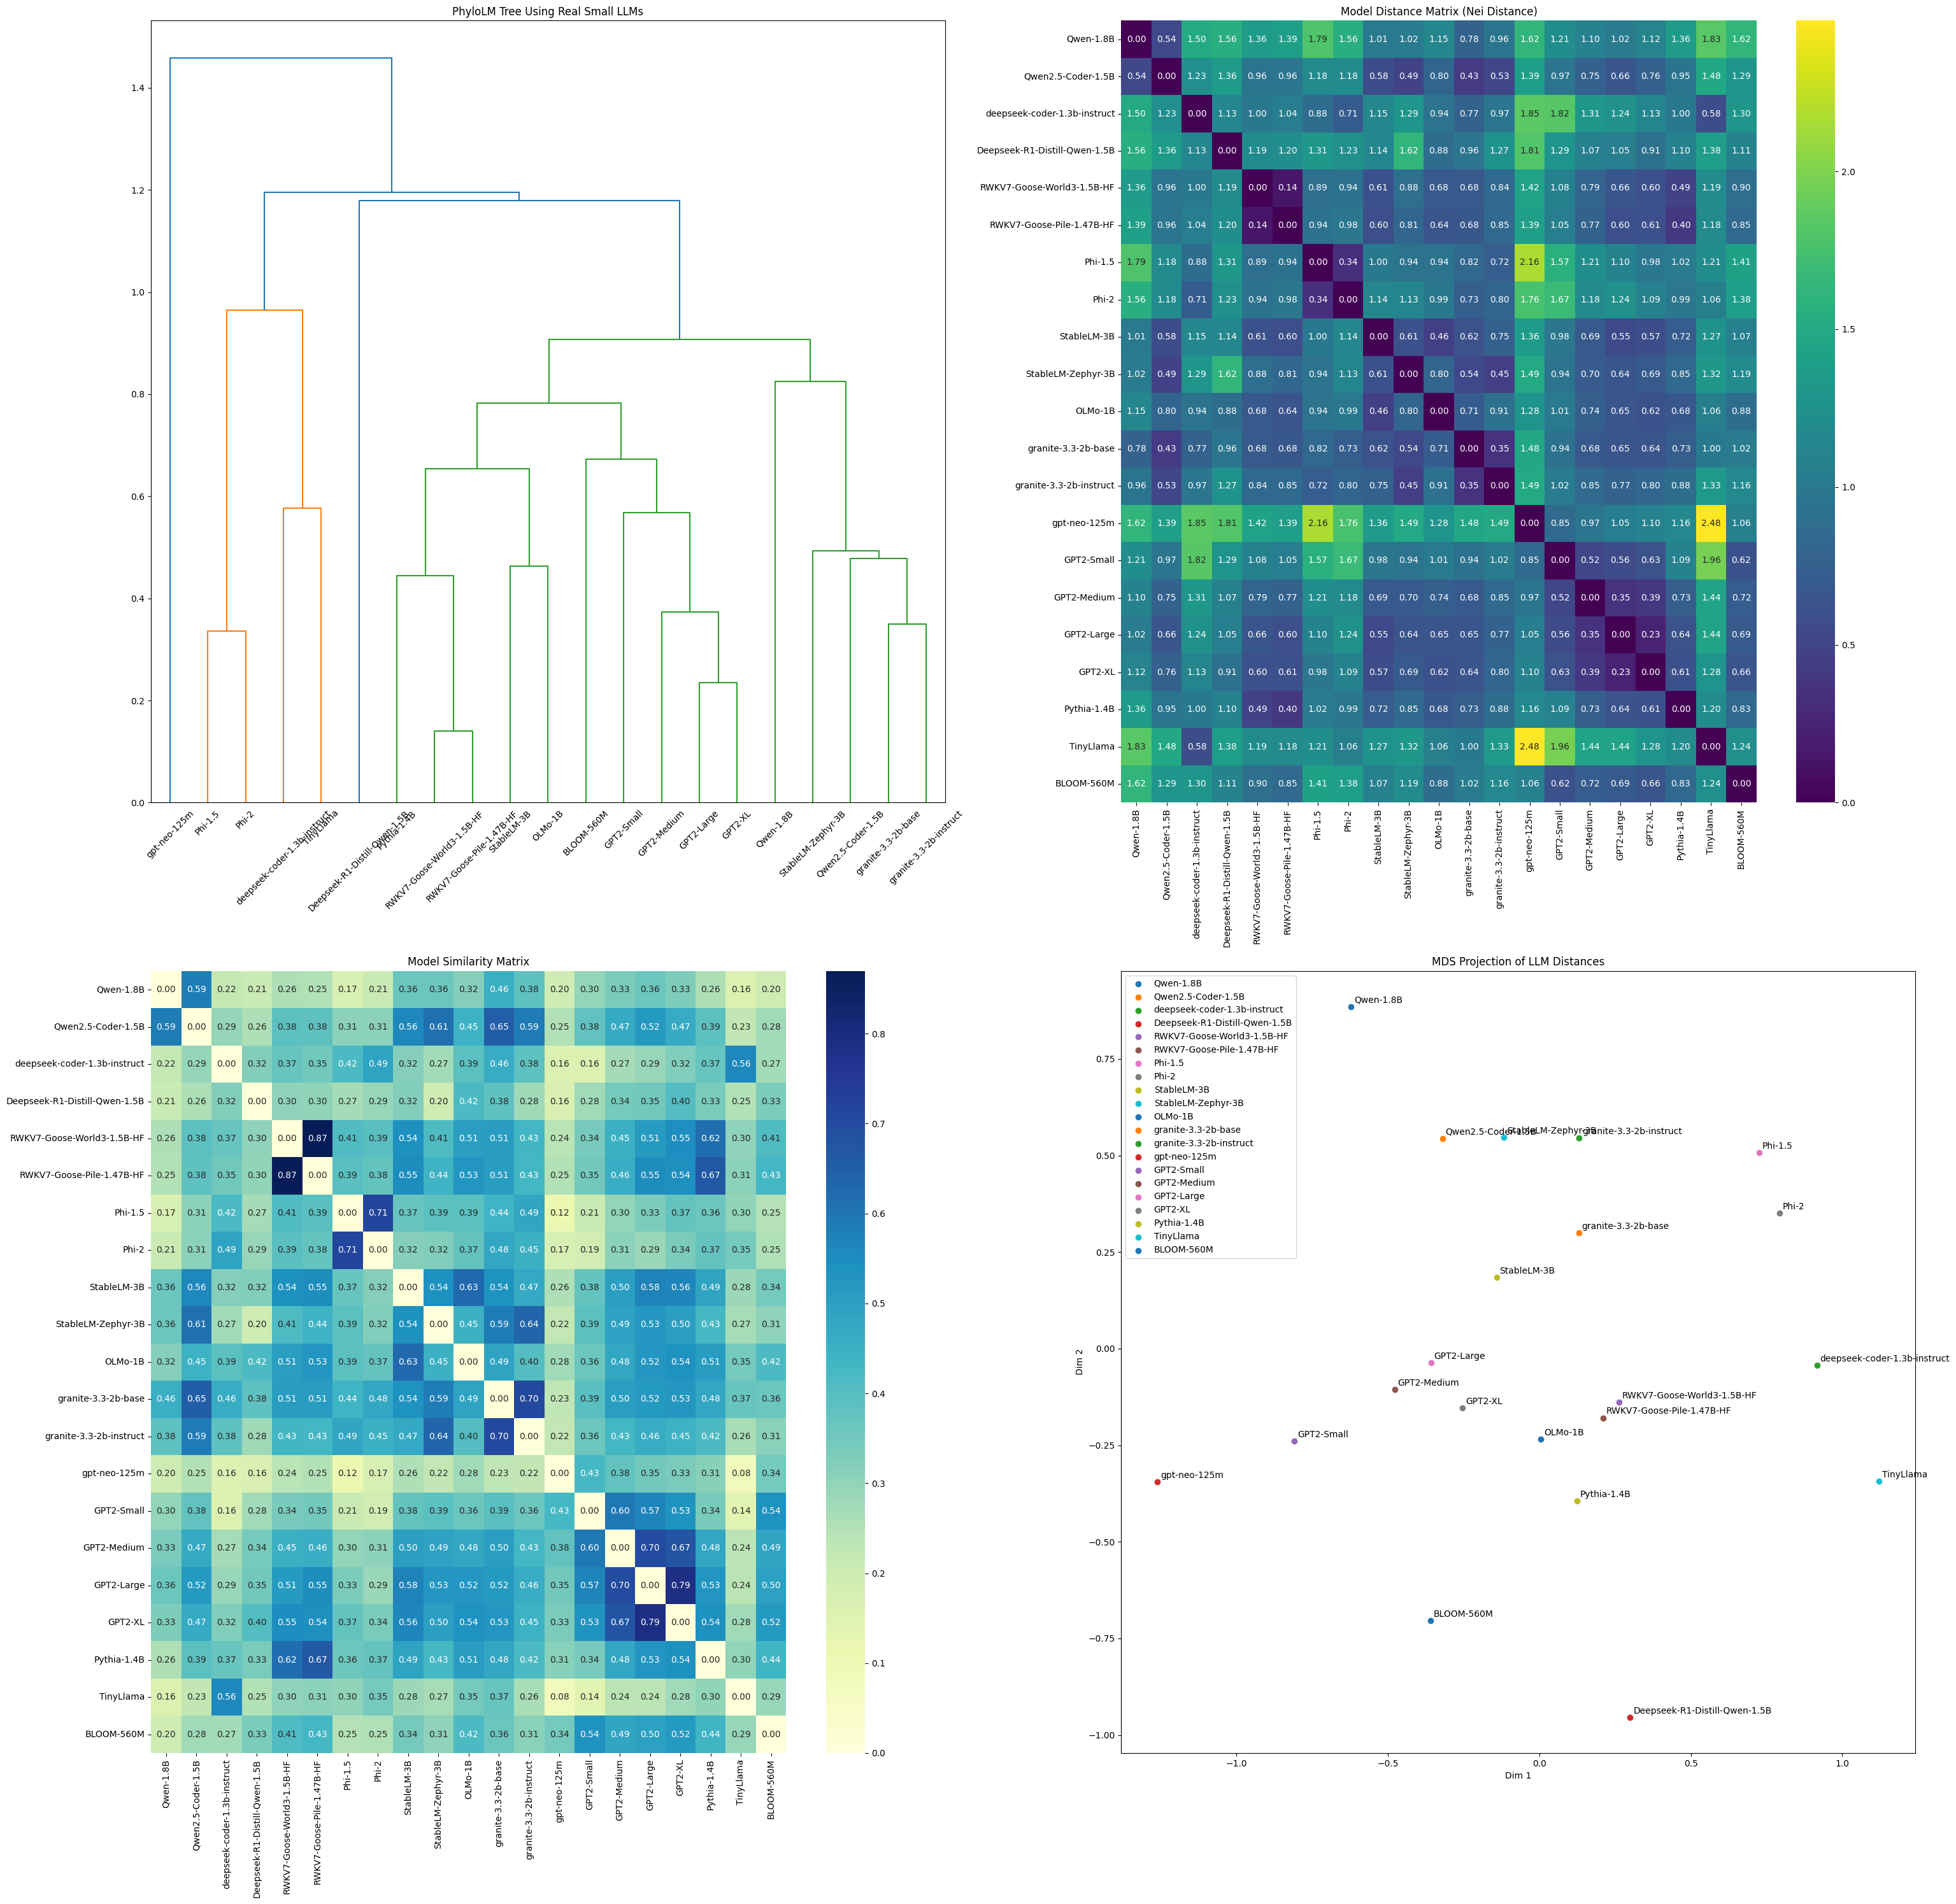

In [ ]:
# -----------------------------
# 6. Visualizations
# -----------------------------

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.manifold import MDS
from scipy.spatial.distance import squareform

# Create the figure with a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(31, 30))

# Plot 1: Dendrogram
condensed = squareform(distance_matrix)
linked = linkage(condensed, method='average')
dendrogram(linked, labels=model_names, ax=axes[0, 0])
axes[0, 0].set_title("PhyloLM Tree Using Real Small LLMs")

# Plot 2: Distance Matrix Heatmap
sns.heatmap(distance_matrix, xticklabels=model_names, yticklabels=model_names, cmap="viridis", annot=True, fmt=".2f", ax=axes[0, 1])
axes[0, 1].set_title("Model Distance Matrix (Nei Distance)")

# Plot 3: Similarity Matrix Heatmap
sns.heatmap(sim_matrix, xticklabels=model_names, yticklabels=model_names, cmap="YlGnBu", annot=True, fmt=".2f", ax=axes[1, 0])
axes[1, 0].set_title("Model Similarity Matrix")

# Plot 4: MDS Projection
points = MDS(n_components=2, dissimilarity='precomputed', random_state=42).fit_transform(distance_matrix)
for i, name in enumerate(model_names):
    axes[1, 1].scatter(points[i, 0], points[i, 1], label=name)
    axes[1, 1].text(points[i, 0]+0.01, points[i, 1]+0.01, name)
axes[1, 1].set_title("MDS Projection of LLM Distances")
axes[1, 1].set_xlabel("Dim 1")
axes[1, 1].set_ylabel("Dim 2")
axes[1, 1].legend()

# Adjust layout
plt.tight_layout()
plt.show()